In [1]:
from IPython.display import Image 
import glob
from matplotlib import pyplot as plt
from skimage.feature import hog
import cv2 as cv
import numpy as np

In [2]:
from skimage.transform import rescale
from skimage.color import rgb2grey

In [98]:
class ScanImage(object):
    WIN = 64
    STEP = 4
    def __init__(self, image):
        self.image_original = image
        self.height = image.shape[0]
        self.width = image.shape[1]
        self.image = rgb2grey(image)
        
    def scan_horizontal(self, row):
        hog_features = []
        positions = []
        for w in range(0, self.width-WIN, STEP):
            sub_image = self.image[row:row+WIN, w:w+WIN]
            hog_features.append(hog(sub_image))
            positions.append((w, row))
        return hog_features, positions       
    
    def detect_car(self, h_features, h_positions, clf):
        preds = clf.predict(h_features)
        for pred, coor in zip(preds, h_positions):
            if pred == 1:
                cv.rectangle(self.image_original, coor, (coor[0]+WIN, coor[1]+WIN), (0, 255, 0), 2)
        return self.image_original

In [128]:
def get_full_images():
    images_files = glob.glob('object-detection-crowdai/*.jpg')
    for image in images_files:
        print image
        yield(cv.imread(image))

In [139]:
def down_scale(im, ratio=1.0/4.0):
    image_2 = rescale(im, ratio)
    plt.imshow(image_2)
    return image_2

In [140]:
im_iter = get_full_images()

object-detection-crowdai/1479502175725780834.jpg


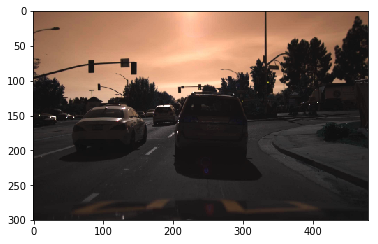

In [197]:
im = im_iter.next()
image = down_scale(im)
height, width, _ = image.shape

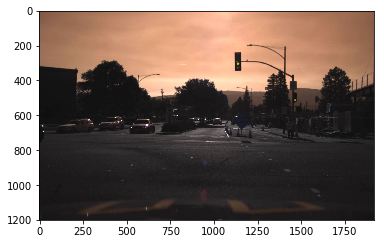

In [225]:
img = cv.imread(images_files[3])
plt.imshow(img)

(array([1.00000e+00, 2.00000e+00, 3.00000e+00, 6.00000e+00, 8.00000e+00,
        6.00000e+00, 6.00000e+00, 2.30000e+01, 1.50000e+01, 2.30000e+01,
        4.20000e+01, 6.10000e+01, 1.51000e+02, 3.41000e+02, 8.48000e+02,
        1.69390e+04, 7.38700e+03, 8.11030e+04, 2.26459e+05, 2.01485e+05,
        6.82580e+04, 1.50977e+05, 1.45171e+05, 9.68580e+04, 2.62360e+05,
        2.12550e+05, 2.57859e+05, 1.60546e+05, 1.97593e+05, 1.57080e+05,
        1.43242e+05, 1.95474e+05, 1.65639e+05, 1.87977e+05, 1.30725e+05,
        1.52712e+05, 1.10021e+05, 1.16708e+05, 8.09260e+04, 8.25260e+04,
        6.27660e+04, 5.70360e+04, 5.65230e+04, 4.93030e+04, 4.74700e+04,
        3.91550e+04, 3.88060e+04, 3.48540e+04, 3.37230e+04, 2.89760e+04,
        2.68270e+04, 2.44310e+04, 2.29300e+04, 2.40020e+04, 2.31080e+04,
        2.30760e+04, 2.00200e+04, 2.02740e+04, 1.88040e+04, 1.91880e+04,
        1.82450e+04, 1.75720e+04, 1.66160e+04, 1.49930e+04, 1.43640e+04,
        1.39410e+04, 1.26110e+04, 1.15560e+04, 1.16

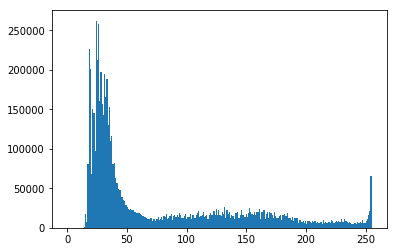

In [226]:
plt.hist(img.ravel(), 256, [0, 255])

In [221]:
plt.show()

In [198]:
scan_image = ScanImage(image)

In [199]:
h_features, h_positions = scan_image.scan_horizontal(110)

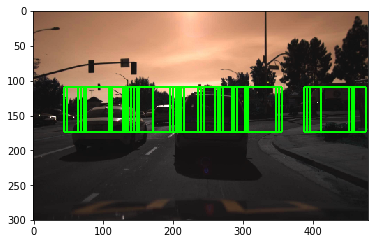

In [200]:
image = scan_image.detect_car(h_features, h_positions, clf)
plt.imshow(image)

### Train SVM 

In [11]:
from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.svm import SVC
from collections import Counter

In [160]:
from sklearn.model_selection import train_test_split
import numpy as np

In [184]:
from sklearn.model_selection import cross_val_score

In [23]:
def cal_class_weight(labels):
    label_freq = Counter(labels)
    class_weight = {}
    total = 0
    for k, v in label_freq.items():
        weight = np.log(v)/float(v+3)
        total += weight 
        class_weight[k] = v
    return class_weight

In [195]:
vehicles = glob.glob('OwnCollection/vehicles/*/*.png')
scenes = glob.glob('OwnCollection/non-vehicles/*/*.png')
train_imgs = vehicles + scenes

labels = [1]*len(vehicles) + [0]*len(scenes)

hog_features = []

for img_file in train_imgs:
    im = cv.imread(img_file, 0)
    feature = hog(im)
    hog_features.append(feature)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.4, random_state=0)
clf = SVC(class_weight=cal_class_weight(y_train)).fit(X_train, y_train)
predicts = clf.predict(X_test)

In [179]:
correct, incorrect = 0, 0

for pred , label in zip(predicts, y_test):
    if pred == label:
        correct += 1
    else:
        incorrect += 1

print "correct: {}, incorrect: {}".format(correct, incorrect)

In [190]:
Counter(labels)

Counter({0: 975, 1: 3425})

In [185]:
scores = cross_val_score(clf, hog_features, labels, cv=5)
print scores

In [ ]:
import pickle

In [ ]:
pickle.dump(clf, open('svm_classifier.pkl', 'wb'))